In [1]:
import pandas as pd

In [2]:
ipca = pd.read_csv('results-20210713-203638.csv')

### agrupando os dados do índice de preços por ano

In [3]:
ipca_ano = ipca.groupby('ano').sum()

### quero normalizar o somatório anual do índice de preços

In [4]:
import numpy as np

In [5]:
ipca_ano['normalized']=ipca_ano['indice']/7998.59

In [6]:
ipca_ano=ipca_ano.drop(columns=['mes'])

In [7]:
ipca_ano.head()

,indice,normalized
ano,,
1994,7998.59,1.000000
1995,13353.08,1.669429
1996,15529.67,1.941551
1997,16619.46,2.077799
1998,17185.64,2.148584


### carregando a série histórica de desemprego da PNADC

Os microdados vêm relacionados por trimestre e ano. A série histórica se inicia em 2012; irei utilizar apenas dados referentes ao último trimestre de cada ano, já que estou utilizando o acumulado do índice de preços anual como referência.

In [8]:
pnad = pd.read_csv('PNADC.csv')

In [9]:
pnad=pnad.rename(columns={'vd4001':'forca_trabalho','vd4002':'ocupacao','vd4009':'condicao_na_ocupacao'})

In [10]:
def selecao(ano):
    return pnad[pnad['ano']==ano]
def forcat(ano):
    return ano[ano['forca_trabalho']==1]
def desem(ano):
    return ano[ano['ocupacao']==2]

In [11]:
forca_de_trabalho=[]
desempregados=[]
ano=[]
for i in range(2012,2020+1):
    df_ano_selecionado=selecao(i)
    forca_de_trabalho.append(len(forcat(df_ano_selecionado)))
    desempregados.append(len(desem(df_ano_selecionado)))
    ano.append(i)

agora, preciso criar a taxa de desemprego anual: verifico a quantidade de pessoas na força de trabalho e utilizo a razão desempregados/força de trabalho

In [12]:
desemp=pd.DataFrame({'forca_de_trabalho':forca_de_trabalho,'desemprego(pessoas)':desempregados,'ano':ano})
desemp['taxa_desemp']=(desemp['desemprego(pessoas)']/desemp['forca_de_trabalho'])*100

In [13]:
agregado=desemp.join(ipca_ano,on='ano')

In [15]:
agregado.head()

,forca_de_trabalho,desemprego(pessoas),ano,taxa_desemp,indice,normalized
0,260765,17234,2012,6.609016,41173.13,5.147549
1,266735,15675,2013,5.876619,43716.00,5.465463
2,270382,16260,2014,6.013714,46457.52,5.808214
3,266631,21727,2015,8.148715,50583.44,6.324045
4,268766,30555,2016,11.368625,55147.36,6.894635


In [23]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

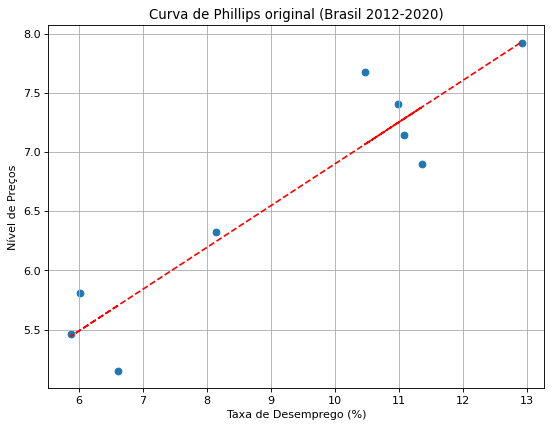

In [24]:
figure(figsize=(8, 6), dpi=80)
plt.scatter(agregado['taxa_desemp'],agregado['normalized'])
plt.xlabel('Taxa de Desemprego (%)')
plt.ylabel('Nível de Preços')
plt.grid()
plt.title('Curva de Phillips original (Brasil 2012-2020)')

z = np.polyfit(agregado['taxa_desemp'], agregado['normalized'], 1)
p = np.poly1d(z)
plt.plot(agregado['taxa_desemp'],p(agregado['taxa_desemp']),"r--")
plt.show()

### Agora, criando a curva de Phillips ampliada às expectativas

In [25]:
variacao=[]
for i in range(1,len(ipca_ano.iloc[:,1])): 
    variacao.append((ipca_ano.iloc[i,1]-ipca_ano.iloc[i-1,1])/(ipca_ano.iloc[i-1,1]))

In [26]:
variacao.insert(0,0)

In [27]:
variacao[:5] #apenas mostrando algumas linhas da lista

[0,
 0.6694292369030042,
 0.16300284278982846,
 0.07017470429184898,
 0.03406729219842288]

In [28]:
ipca_ano['var%']=variacao

In [30]:
agregad2=desemp.join(ipca_ano,on='ano')

In [31]:
agregad2.head()

,forca_de_trabalho,desemprego(pessoas),ano,taxa_desemp,indice,normalized,var%
0,260765,17234,2012,6.609016,41173.13,5.147549,0.055153
1,266735,15675,2013,5.876619,43716.00,5.465463,0.061760
2,270382,16260,2014,6.013714,46457.52,5.808214,0.062712
3,266631,21727,2015,8.148715,50583.44,6.324045,0.088811
4,268766,30555,2016,11.368625,55147.36,6.894635,0.090226


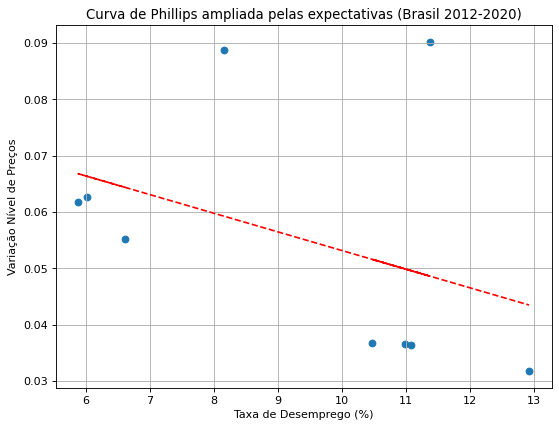

In [32]:
figure(figsize=(8, 6), dpi=80)
plt.scatter(agregad2['taxa_desemp'],agregad2['var%'])
plt.xlabel('Taxa de Desemprego (%)')
plt.ylabel('Variação Nível de Preços')
plt.grid()
plt.title('Curva de Phillips ampliada pelas expectativas (Brasil 2012-2020)')

z = np.polyfit(agregad2['taxa_desemp'], agregad2['var%'], 1)
p = np.poly1d(z)
plt.plot(agregad2['taxa_desemp'],p(agregad2['taxa_desemp']),"r--")
plt.show()